# Topic Modeling with Twitter Data

## Package Imports

In [18]:
import sys
from os import getcwd
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS, WordCloud
import gensim
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora
from pprint import pprint
import string
import os
import re

We need some code that is inside the parent directory of where we are. Inorder for import to work I will add the
parent directory to the system path

In [2]:
cwd = getcwd()
parent = cwd.replace('/notebooks', '')
sys.path.insert(0, parent) 

from extract_dataframe import read_json
from extract_dataframe import TweetDfExtractor
from clean_tweets_dataframe import CleanTweets
from tweets_preprocess import SADataPreparation
from utils import DataLoader

In [3]:
DataLoader_obj= DataLoader("../", "processed_tweet_data.csv")

In [4]:
tweets_df = DataLoader_obj.read_csv()
# tweets_df.dropna()
# tweets_df.reset_index(drop=True, inplace=True)
print("len: ", len(tweets_df))
tweets_df.head()

len:  24637


,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:20:18 +0000 2022,Twitter for Android,RT @nikitheblogger: Irre: Annalena Baerbock sa...,0.0,0.0,de,0,355.0,McMc74078966,3,12,NaN,[],['nikitheblogger'],NaN
1,Fri Apr 22 22:19:16 +0000 2022,Twitter for Android,RT @sagt_mit: Merkel schaffte es in 1 Jahr 1 M...,0.0,0.0,de,0,505.0,McMc74078966,3,12,NaN,[],['sagt_mit'],NaN
2,Fri Apr 22 22:17:28 +0000 2022,Twitter for Android,RT @Kryptonoun: @WRi007 Pharma in Lebensmittel...,0.0,0.0,de,0,4.0,McMc74078966,3,12,NaN,[],"['Kryptonoun', 'WRi007']",NaN
3,Fri Apr 22 22:17:20 +0000 2022,Twitter for Android,RT @WRi007: Die #Deutschen sind ein braves Vol...,0.0,0.0,de,0,332.0,McMc74078966,3,12,NaN,"['Deutschen', 'Spritpreisen', 'inflation', 'Ab...",['WRi007'],NaN
4,Fri Apr 22 22:13:15 +0000 2022,Twitter for Android,RT @RolandTichy: Baerbock verkündet mal so neb...,0.0,0.0,de,0,386.0,McMc74078966,3,12,NaN,[],['RolandTichy'],NaN


## Text Data Preparation

## Data Cleaner
We have imported the `CleanTweets` class for this task.

In [5]:
cleaner = CleanTweets()
cleaned_df = cleaner.run_pipeline(tweets_df)
cleaned_df.head()

Automation in Action...!!!


,created_at,source,clean_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-04-22 22:32:03+00:00,twitter for iphone,mickey bad move signed bill strips disney self...,-0.037500,0.533333,en,1,0.0,mercuryreports,9254,9422,False,[],['govrondesantis'],all over america
1,2022-04-22 22:16:55+00:00,twitter for iphone,elections consequences biden historic mishandl...,-0.066667,0.033333,en,1,0.0,mercuryreports,9254,9422,False,[],[],all over america
2,2022-04-22 07:15:28+00:00,twitter for iphone,coincidence food processing facilities burned ...,-0.077778,0.177778,en,4,1.0,mercuryreports,9254,9422,False,[],[],all over america
3,2022-04-22 07:11:18+00:00,twitter for iphone,food processing plants destroyed small plane c...,-0.100000,0.450000,en,3,2.0,mercuryreports,9254,9422,False,[],[],all over america
4,2022-04-22 07:07:13+00:00,twitter for iphone,democrats make evil big corporations pay fair ...,0.000000,0.666667,en,0,5465.0,mercuryreports,9254,9422,False,[],['catturd2'],all over america


In [6]:
class PrepareData:
    def __init__(self,df):
        self.df=df

    def preprocess_data(self):
        tweets_df = self.df.loc[self.df['lang'] =="en"]


        #text Preprocessing
        tweets_df['clean_text'] = tweets_df['clean_text'].astype(str)
        tweets_df['clean_text'] = tweets_df['clean_text'].apply(
            lambda x: x.lower())
        tweets_df['clean_text'] = tweets_df['clean_text'].apply(
            lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

        #Converting tweets to list of words For feature engineering
        sentence_list = [tweet for tweet in tweets_df['clean_text']]
        word_list = [sent.split() for sent in sentence_list]

        #Create dictionary which contains Id and word 
        word_to_id = corpora.Dictionary(word_list)
        corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]




        return word_list, word_to_id, corpus_1

In [7]:
PrepareData_obj = PrepareData(cleaned_df)
word_list, id2word, corpus = PrepareData_obj.preprocess_data()

In [8]:
print(len(corpus))

10664


### Topic Modeling using Latent Dirichlet Allocation 
based on the distributional hypothesis, (i.e. similar topics make use of similar words) and the statistical mixture hypothesis (i.e. documents talk about several topics) for which a statistical distribution can be determined. 

*  The purpose of LDA is mapping each tweet in our corpus to a set of topics which covers a good deal of the words in the tweet

In [9]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=512,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [10]:
pprint(lda_model.show_topics(formatted=False))

[(5,
  [('never', 0.051503416),
   ('president', 0.045191918),
   ('happy', 0.035241134),
   ('story', 0.026359703),
   ('change', 0.024442462),
   ('times', 0.022346105),
   ('due', 0.01963114),
   ('lost', 0.018768424),
   ('fire', 0.017805774),
   ('tell', 0.016717289)]),
 (6,
  [('us', 0.09532689),
   ('world', 0.056925062),
   ('country', 0.046908494),
   ('let', 0.04447643),
   ('days', 0.038131073),
   ('supply', 0.024951294),
   ('person', 0.023584122),
   ('top', 0.02150296),
   ('hate', 0.021170367),
   ('via', 0.01986353)]),
 (4,
  [('first', 0.042705078),
   ('said', 0.0397744),
   ('police', 0.037739284),
   ('protest', 0.032066178),
   ('everyone', 0.024514109),
   ('road', 0.024240451),
   ('sure', 0.021750124),
   ('st', 0.017612934),
   ('economy', 0.017338581),
   ('enough', 0.016589804)]),
 (14,
  [('man', 0.06345035),
   ('go', 0.04536654),
   ('life', 0.031479202),
   ('thank', 0.029194653),
   ('thanks', 0.025381127),
   ('leader', 0.020579193),
   ('bank', 0.0192

# **Model Analysis**

Perplexity is also a measure of model quality and in natural language processing is often used as “perplexity per number of words”. It describes how well a model predicts a sample, i.e. how much it is “perplexed” by a sample from the observed data. The lower the score, the better the model for the given data.

A coherence matrix is used to test the model for accuracy. Topic coherence is a measure that compares different topic models based on their human-interpretability. The coherence score ‘C_V’ provides a numerical value to the interpretability of the topics

In [14]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -16.235870187650722

 Ldamodel Coherence Score/Accuracy on Tweets:  0.5498485785770549


**Anlayizing results**
Exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics

In [12]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/si

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.362752  0.063870       1        1  10.798478
8      0.035183 -0.321606       2        1   8.582426
13    -0.042970  0.087813       3        1   7.776915
9     -0.040817  0.093325       4        1   7.679238
11    -0.033952 -0.029215       5        1   7.523781
10    -0.038340  0.058496       6        1   7.308623
2     -0.027406  0.000867       7        1   6.460711
7     -0.027181  0.026825       8        1   6.403259
12     0.001511 -0.049007       9        1   6.343637
1     -0.031074 -0.027599      10        1   5.924906
3     -0.033116  0.025591      11        1   5.459163
14    -0.031901  0.022642      12        1   5.255225
6     -0.032512  0.015009      13        1   5.183991
4     -0.030630  0.017463      14        1   5.159180
5     -0.029547  0.015524      15        1   4.140469, topic_info=          Term        Freq       Total Category  logprob  loglift
397        amp  876.000000  876.000000  Default  30.0000  30.0000
3387     india  738.000000  738.000000  Default  29.0000  29.0000
58         one  676.000000  676.000000  Default  28.0000  28.0000
1174    follow  680.000000  680.000000  Default  27.0000  27.0000
176     people  615.000000  615.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
350       risk   31.613687   33.083236  Topic15  -4.7243   3.1389
1127     truly   29.402050   30.871599  Topic15  -4.7968   3.1356
8302  ensuring   28.034524   29.504073  Topic15  -4.8445   3.1333
946    holding   27.628051   29.097601  Topic15  -4.8591   3.1325
809      sales   26.695246   28.164795  Topic15  -4.8934   3.1308

[497 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1020      5  0.984112       able
1774     14  0.968751    accused
1208      3  0.985043     across
470       5  0.983368     action
1116     12  0.942451    actions
...     ...       ...        ...
650      10  0.361281      years
1103     10  0.982326        yes
198       5  0.969801  yesterday
236      11  0.980255        yet
1954      2  0.968988    youtube

[483 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 14, 10, 12, 11, 3, 8, 13, 2, 4, 15, 7, 5, 6])

# With sklearn

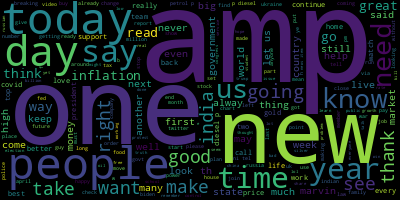

In [48]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot
%matplotlib inline

long_string = " ".join(cleaned_df['clean_text'])
wordcloud = WordCloud(stopwords = STOPWORDS)
wordcloud.generate(long_string)
wordcloud.to_image()

/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


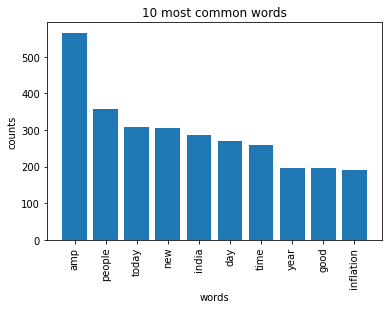

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()
    
    
count_vectorizer = CountVectorizer(
                                strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10
                                  )

count_data = count_vectorizer.fit_transform(cleaned_df['clean_text'])

tfidf_vectorizer = TfidfVectorizer(**count_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(cleaned_df['clean_text'])

plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [22]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
             for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 1
number_words = 5

lda = LDA(n_components=number_topics)
lda.fit(count_data)

print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
amp people today new india


In [65]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm_tfidf, count_vectorizer)

/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/si

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.040290  0.013486       1        1  7.322251
1      0.080219 -0.044221       2        1  7.248050
13    -0.076289 -0.030582       3        1  6.959614
14     0.061191 -0.120022       4        1  6.947225
7     -0.006851  0.303350       5        1  6.853473
0      0.117944 -0.075677       6        1  6.853134
4      0.143007  0.031240       7        1  6.684651
5     -0.010415 -0.061872       8        1  6.601238
8     -0.167033  0.175260       9        1  6.522102
10     0.072730 -0.003178      10        1  6.474647
2      0.037593  0.093864      11        1  6.453759
11     0.121104 -0.035190      12        1  6.347420
3     -0.283874 -0.131061      13        1  6.265589
12    -0.096298 -0.093906      14        1  6.235836
9      0.047262 -0.021491      15        1  6.231012, topic_info=            Term        Freq       Total Category  logprob  loglift
989       people  147.000000  147.000000  Default  30.0000  30.0000
574         good   84.000000   84.000000  Default  29.0000  29.0000
518       follow   61.000000   61.000000  Default  28.0000  28.0000
681    inflation   84.000000   84.000000  Default  27.0000  27.0000
743         know   80.000000   80.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
698   investment    9.218939   14.936205  Topic15  -4.9117   2.2931
907     multiple    8.194046   11.742653  Topic15  -5.0295   2.4158
1393       today   14.618770  133.598187  Topic15  -4.4506   0.5631
46           amp   16.573852  238.832038  Topic15  -4.3251   0.1077
696       invest    8.221436   17.344725  Topic15  -5.0262   2.0291

[787 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         3  0.154001     access
3         7  0.770003     access
4         3  0.105654  according
4         9  0.105654  according
4        12  0.633926  according
...     ...       ...        ...
1558     11  0.970854        yes
1559     11  0.148134  yesterday
1559     12  0.839427  yesterday
1559     14  0.049378  yesterday
1565      1  0.879624    youtube

[1563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 14, 15, 8, 1, 5, 6, 9, 11, 3, 12, 4, 13, 10])

The topics at the unmber 13 bubble are relate to economic hardship 

# Measuring model performance and using grid search for optimal number of topics

In [72]:
# train_gamma = lda.transform(count_data)
lda.perplexity(count_data, False)

1523.8841207003677

In [73]:
for n_comp in range(1, 16, 1):
    lda = LDA(n_components=number_topics)
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data, False)
    print(f"{n_comp} comp\tperplexity:\t{perplexity}")

1 comp	perplexity:	1507.4415660339062
2 comp	perplexity:	1523.4964767971765
3 comp	perplexity:	1491.395112899848
4 comp	perplexity:	1516.27720394732
5 comp	perplexity:	1509.5599970923593
6 comp	perplexity:	1529.7161577028219
7 comp	perplexity:	1512.2787312779833
8 comp	perplexity:	1500.4725484994635
9 comp	perplexity:	1495.2253885509886
10 comp	perplexity:	1504.736915003974
11 comp	perplexity:	1528.725341773082
12 comp	perplexity:	1516.4295623346684
13 comp	perplexity:	1530.1992992502182
14 comp	perplexity:	1511.5554274334556
15 comp	perplexity:	1506.1841677788027


In [75]:
np.log(1491)

7.307202314764738

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
        # ('vec', CountVectorizer()),
        # ('tf_vectorize', TfidfVectorizer()), 
        ('model', LDA())
    ])

parameters = {
    # 'vec__ngram_range': ((1, 1), (1, 2), (1, 3)),
    # 'tf_vectorize__use_idf': [True, False],
    'model__n_components': [3, 5, 8, 10]
}


grid_search_cv = GridSearchCV(pipeline,
    parameters,
    cv=5,
    n_jobs=-1
    )
grid_search_cv.fit(count_data)
print(f'Best params: {grid_search_cv.best_params_}')
print(f'Best score: {grid_search_cv.best_score_}')

Best params: {'model__n_components': 3}
Best score: -72936.06964264916


In [31]:
lda = LDA(n_components=3)
lda.fit(count_data)

LatentDirichletAllocation(n_components=3)

In [32]:
perplexity = lda.perplexity(count_data, True)
perplexity

1141.199093429941